In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chennai-housing-sales-price:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2301994%2F3873117%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240305%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240305T053558Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D84a0ff75b3d4af7bbdfff187ec4f934897f9ed82a4196f0dbf5548472f3d13bd6ada9956c1a540f9a6606f14e937540e03dd123f6b8a36c7524d4500f097c0f8115a00bb418b227ba708f8fdf5d4ab96f6c14fd3bec82f63c30fc79c8e5f897a7448b546f46a800fabe7f5d1bcde153f5331fe50776b377f4f5a401a8b4de7255f1d161bb171713f0e9fdfb6380d13950f9fc12c155c21c019eba3a11a89b8f85c6ee3dd5918667db97cc673169b03ecc91dbe287a6e259b5e13051fa23a9784bce34674da347833b1460db8743e8ea24e34840b278d6c622642526afd57733c4f4ddf49a511f7f2f7a28852ea42f7274bd5184f4dbb3c717fbc91e1f3a12e71'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 287806 bytes downloaded
Downloaded and uncompressed: chennai-housing-sales-price
Data source import complete.


In [2]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/chennai-housing-sales-price/Chennai houseing sale.csv


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')

In [5]:
df=pd.read_csv("/kaggle/input/chennai-housing-sales-price/Chennai houseing sale.csv")
df.head()

,PRT_ID,AREA,INT_SQFT,DATE_SALE,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,...,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,REG_FEE,COMMIS,SALES_PRICE
0,P03210,Karapakkam,1004,04-05-2011,131,1.00,1.00,3,AbNormal,Yes,...,AllPub,Paved,A,4.00,3.90,4.90,4.33,380000,144400,7600000
1,P09411,Anna Nagar,1986,19-12-2006,26,2.00,1.00,5,AbNormal,No,...,AllPub,Gravel,RH,4.90,4.20,2.50,3.77,760122,304049,21717770
2,P01812,Adyar,909,04-02-2012,70,1.00,1.00,3,AbNormal,Yes,...,ELO,Gravel,RL,4.10,3.80,2.20,3.09,421094,92114,13159200
3,P05346,Velachery,1855,13-03-2010,14,3.00,2.00,5,Family,No,...,NoSewr,Paved,I,4.70,3.90,3.60,4.01,356321,77042,9630290
4,P06210,Karapakkam,1226,05-10-2009,84,1.00,1.00,3,AbNormal,Yes,...,AllPub,Gravel,C,3.00,2.50,4.10,3.29,237000,74063,7406250


In [6]:
df1=df.drop(['QS_OVERALL','QS_BEDROOM','QS_BATHROOM','QS_ROOMS','MZZONE','DATE_SALE','N_ROOM','SALE_COND','DATE_BUILD','DIST_MAINROAD'],axis='columns')
df1.head()

,PRT_ID,AREA,INT_SQFT,N_BEDROOM,N_BATHROOM,PARK_FACIL,BUILDTYPE,UTILITY_AVAIL,STREET,REG_FEE,COMMIS,SALES_PRICE
0,P03210,Karapakkam,1004,1.00,1.00,Yes,Commercial,AllPub,Paved,380000,144400,7600000
1,P09411,Anna Nagar,1986,2.00,1.00,No,Commercial,AllPub,Gravel,760122,304049,21717770
2,P01812,Adyar,909,1.00,1.00,Yes,Commercial,ELO,Gravel,421094,92114,13159200
3,P05346,Velachery,1855,3.00,2.00,No,Others,NoSewr,Paved,356321,77042,9630290
4,P06210,Karapakkam,1226,1.00,1.00,Yes,Others,AllPub,Gravel,237000,74063,7406250


In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7109 entries, 0 to 7108
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PRT_ID         7109 non-null   object 
 1   AREA           7109 non-null   object 
 2   INT_SQFT       7109 non-null   int64  
 3   N_BEDROOM      7108 non-null   float64
 4   N_BATHROOM     7104 non-null   float64
 5   PARK_FACIL     7109 non-null   object 
 6   BUILDTYPE      7109 non-null   object 
 7   UTILITY_AVAIL  7109 non-null   object 
 8   STREET         7109 non-null   object 
 9   REG_FEE        7109 non-null   int64  
 10  COMMIS         7109 non-null   int64  
 11  SALES_PRICE    7109 non-null   int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 666.6+ KB


In [8]:
df1.isnull().sum()

PRT_ID           0
AREA             0
INT_SQFT         0
N_BEDROOM        1
N_BATHROOM       5
PARK_FACIL       0
BUILDTYPE        0
UTILITY_AVAIL    0
STREET           0
REG_FEE          0
COMMIS           0
SALES_PRICE      0
dtype: int64

In [9]:
df2=df1.dropna()
df2.isnull().sum()

PRT_ID           0
AREA             0
INT_SQFT         0
N_BEDROOM        0
N_BATHROOM       0
PARK_FACIL       0
BUILDTYPE        0
UTILITY_AVAIL    0
STREET           0
REG_FEE          0
COMMIS           0
SALES_PRICE      0
dtype: int64

In [10]:
for col in df2.columns:
    if df2[col].dtype=='object':
        print()
        print(col)
        print(df2[col].unique())


PRT_ID
['P03210' 'P09411' 'P01812' ... 'P09594' 'P06508' 'P09794']

AREA
['Karapakkam' 'Anna Nagar' 'Adyar' 'Velachery' 'Chrompet' 'KK Nagar'
 'TNagar' 'T Nagar' 'Chrompt' 'Chrmpet' 'Karapakam' 'Ana Nagar' 'Chormpet'
 'Adyr' 'Velchery' 'Ann Nagar' 'KKNagar']

PARK_FACIL
['Yes' 'No' 'Noo']

BUILDTYPE
['Commercial' 'Others' 'Other' 'House' 'Comercial']

UTILITY_AVAIL
['AllPub' 'ELO' 'NoSewr ' 'NoSeWa' 'All Pub']

STREET
['Paved' 'Gravel' 'No Access' 'Pavd' 'NoAccess']


In [11]:
df2.AREA.replace(['Ana Nagar','Ann Nagar'],'Anna Nagar',inplace=True)
df2.AREA.replace('Karapakkam','Karapakam',inplace=True)
df2.AREA.replace('Adyr','Adyar',inplace=True)
df2.AREA.replace('Velchery','Velachery',inplace=True)
df2.AREA.replace(['Chormpet','Chrmpet','Chrompt'],'Chrompet',inplace=True)
df2.AREA.replace('KKNagar','KK Nagar',inplace=True)
df2.AREA.replace('TNagar','T Nagar',inplace=True)
df2.PARK_FACIL.replace('Noo','No',inplace=True)
df2.BUILDTYPE.replace('Comercial','Commercial',inplace=True)
df2.BUILDTYPE.replace('Other','Others',inplace=True)
df2.UTILITY_AVAIL.replace(['AllPub','NoSwer','NoSewr ','NoSeWa','All Pub'],'Yes',inplace=True)
df2.UTILITY_AVAIL.replace('ELO','No',inplace=True)
df2.STREET.replace('Pavd','Paved',inplace=True)
df2.STREET.replace('NoAccess','No Access',inplace=True)

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7103 entries, 0 to 7108
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PRT_ID         7103 non-null   object 
 1   AREA           7103 non-null   object 
 2   INT_SQFT       7103 non-null   int64  
 3   N_BEDROOM      7103 non-null   float64
 4   N_BATHROOM     7103 non-null   float64
 5   PARK_FACIL     7103 non-null   object 
 6   BUILDTYPE      7103 non-null   object 
 7   UTILITY_AVAIL  7103 non-null   object 
 8   STREET         7103 non-null   object 
 9   REG_FEE        7103 non-null   int64  
 10  COMMIS         7103 non-null   int64  
 11  SALES_PRICE    7103 non-null   int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 721.4+ KB


In [13]:
df2['total_price']=df2['REG_FEE']+df2['COMMIS']+df2['SALES_PRICE']

In [14]:
df2['N_BEDROOM']=df2['N_BEDROOM'].astype(int)
df2['N_BATHROOM']=df2['N_BATHROOM'].astype(int)

In [15]:
import seaborn as sns

In [16]:
df2.describe()

,INT_SQFT,N_BEDROOM,N_BATHROOM,REG_FEE,COMMIS,SALES_PRICE,total_price
count,7103.00,7103.00,7103.00,7103.00,7103.00,7103.00,7103.00
mean,1382.12,1.64,1.21,376952.71,141055.36,10894773.48,11412781.55
std,457.48,0.80,0.41,143088.11,78775.88,3769548.87,3945930.35
min,500.00,1.00,1.00,71177.00,5055.00,2156875.00,2253935.00
25%,993.00,1.00,1.00,272469.00,84252.50,8270900.00,8645484.50
50%,1373.00,1.00,1.00,349509.00,127644.00,10334640.00,10819523.00
75%,1744.00,2.00,1.00,451544.50,184534.00,12994215.00,13614948.50
max,2500.00,4.00,2.00,983922.00,495405.00,23667340.00,24969043.00


In [17]:
df3=df2.drop(['SALES_PRICE','COMMIS','REG_FEE'],axis='columns')
df3.head()

,PRT_ID,AREA,INT_SQFT,N_BEDROOM,N_BATHROOM,PARK_FACIL,BUILDTYPE,UTILITY_AVAIL,STREET,total_price
0,P03210,Karapakam,1004,1,1,Yes,Commercial,Yes,Paved,8124400
1,P09411,Anna Nagar,1986,2,1,No,Commercial,Yes,Gravel,22781941
2,P01812,Adyar,909,1,1,Yes,Commercial,No,Gravel,13672408
3,P05346,Velachery,1855,3,2,No,Others,Yes,Paved,10063653
4,P06210,Karapakam,1226,1,1,Yes,Others,Yes,Gravel,7717313


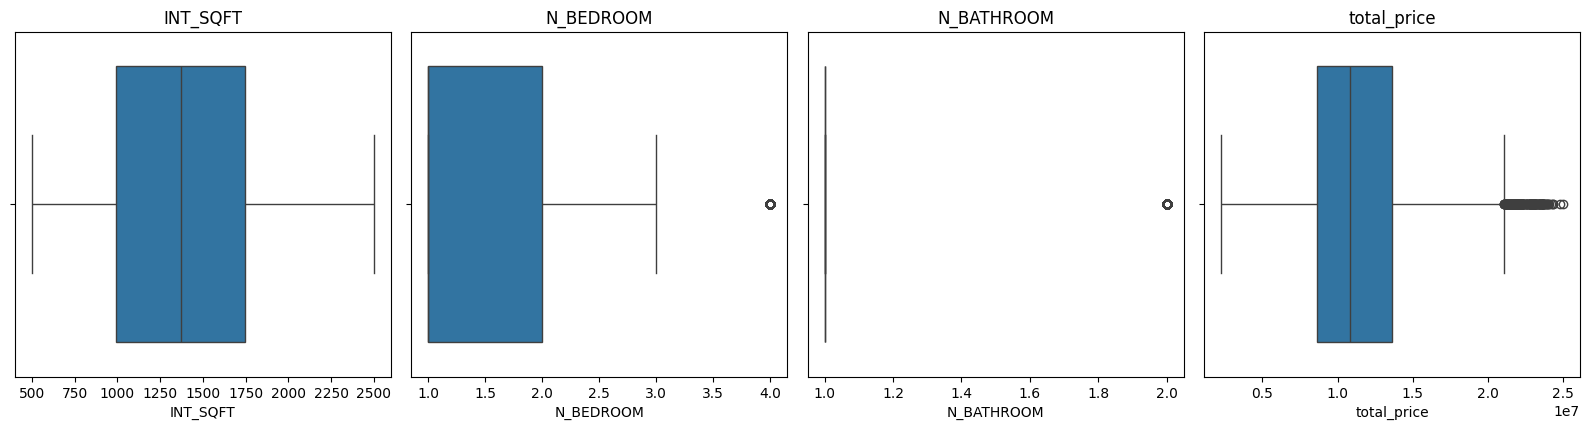

In [18]:
columns_to_analyze = ['INT_SQFT','N_BEDROOM','N_BATHROOM','total_price']

plt.figure(figsize=(16, 8))

for i, column in enumerate(columns_to_analyze):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(x=df3[column])
    plt.title(column)
    plt.tight_layout()

plt.show()

In [19]:
Q1 = df3["total_price"].quantile(0.25)
Q3 = df3["total_price"].quantile(0.75)
IQR = Q3 - Q1

In [20]:
lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR

In [21]:
outlier_mask = (df3["total_price"] < lower_threshold) | (df3["total_price"] > upper_threshold)

In [22]:
df3_cleaned = df3[~outlier_mask]

In [23]:
df4=df3_cleaned.copy()

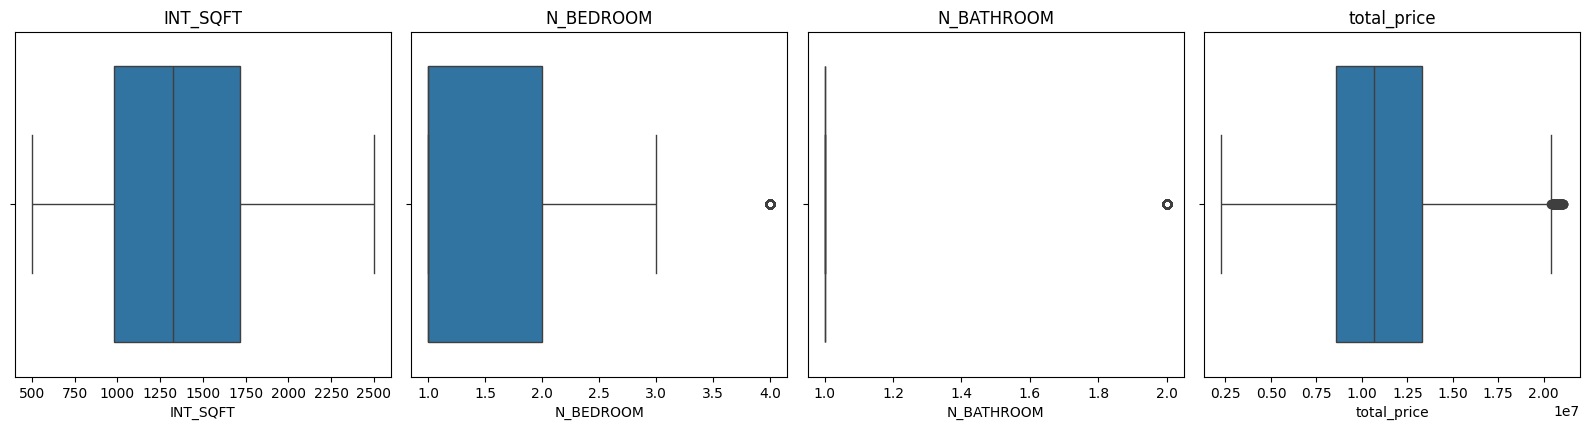

In [24]:
columns_to_analyze = ['INT_SQFT','N_BEDROOM','N_BATHROOM','total_price']

plt.figure(figsize=(16, 8))

for i, column in enumerate(columns_to_analyze):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(x=df4[column])
    plt.title(column)
    plt.tight_layout()

plt.show()

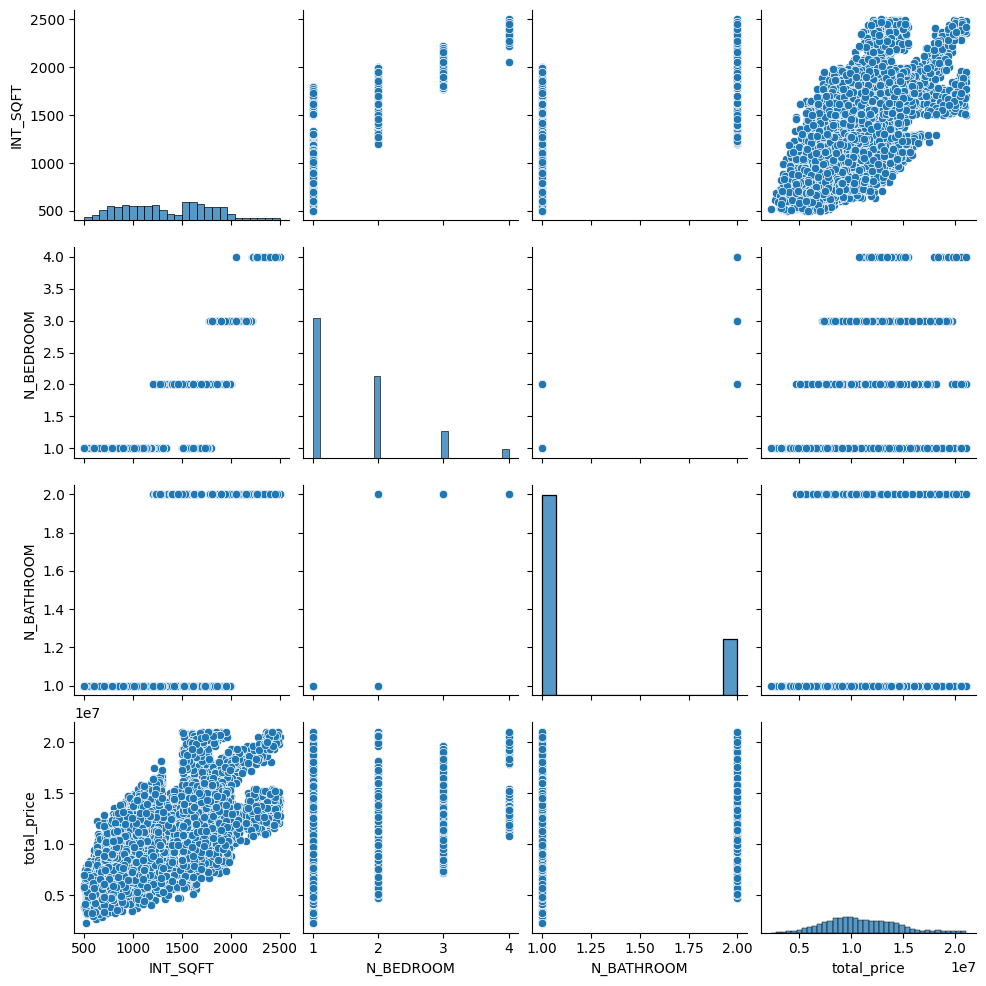

In [25]:
sns.pairplot(df4)
plt.show()

In [26]:
df4.head()

,PRT_ID,AREA,INT_SQFT,N_BEDROOM,N_BATHROOM,PARK_FACIL,BUILDTYPE,UTILITY_AVAIL,STREET,total_price
0,P03210,Karapakam,1004,1,1,Yes,Commercial,Yes,Paved,8124400
2,P01812,Adyar,909,1,1,Yes,Commercial,No,Gravel,13672408
3,P05346,Velachery,1855,3,2,No,Others,Yes,Paved,10063653
4,P06210,Karapakam,1226,1,1,Yes,Others,Yes,Gravel,7717313
5,P00219,Chrompet,1220,2,1,No,Commercial,Yes,No Access,13002093


In [27]:
from sklearn.preprocessing import OneHotEncoder

In [28]:
columns_to_encode = ['AREA','PARK_FACIL','BUILDTYPE','UTILITY_AVAIL','STREET']
encoded_df = pd.get_dummies(df4[columns_to_encode],dtype=int)

In [29]:
encoded_df.head()

,AREA_Adyar,AREA_Anna Nagar,AREA_Chrompet,AREA_KK Nagar,AREA_Karapakam,AREA_T Nagar,AREA_Velachery,PARK_FACIL_No,PARK_FACIL_Yes,BUILDTYPE_Commercial,BUILDTYPE_House,BUILDTYPE_Others,UTILITY_AVAIL_No,UTILITY_AVAIL_Yes,STREET_Gravel,STREET_No Access,STREET_Paved
0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1
2,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0
3,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1
4,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,0,0
5,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0


In [30]:
df5=pd.concat([df4,encoded_df],axis=1)
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6876 entries, 0 to 7108
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   PRT_ID                6876 non-null   object
 1   AREA                  6876 non-null   object
 2   INT_SQFT              6876 non-null   int64 
 3   N_BEDROOM             6876 non-null   int64 
 4   N_BATHROOM            6876 non-null   int64 
 5   PARK_FACIL            6876 non-null   object
 6   BUILDTYPE             6876 non-null   object
 7   UTILITY_AVAIL         6876 non-null   object
 8   STREET                6876 non-null   object
 9   total_price           6876 non-null   int64 
 10  AREA_Adyar            6876 non-null   int64 
 11  AREA_Anna Nagar       6876 non-null   int64 
 12  AREA_Chrompet         6876 non-null   int64 
 13  AREA_KK Nagar         6876 non-null   int64 
 14  AREA_Karapakam        6876 non-null   int64 
 15  AREA_T Nagar          6876 non-null   

In [31]:
df6=df5.copy()

In [32]:
y=df6['total_price']
X=df6.drop(['PRT_ID','PARK_FACIL','BUILDTYPE','UTILITY_AVAIL','STREET','AREA','total_price'],axis='columns')

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=10)

In [34]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4813 entries, 2353 to 1334
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   INT_SQFT              4813 non-null   int64
 1   N_BEDROOM             4813 non-null   int64
 2   N_BATHROOM            4813 non-null   int64
 3   AREA_Adyar            4813 non-null   int64
 4   AREA_Anna Nagar       4813 non-null   int64
 5   AREA_Chrompet         4813 non-null   int64
 6   AREA_KK Nagar         4813 non-null   int64
 7   AREA_Karapakam        4813 non-null   int64
 8   AREA_T Nagar          4813 non-null   int64
 9   AREA_Velachery        4813 non-null   int64
 10  PARK_FACIL_No         4813 non-null   int64
 11  PARK_FACIL_Yes        4813 non-null   int64
 12  BUILDTYPE_Commercial  4813 non-null   int64
 13  BUILDTYPE_House       4813 non-null   int64
 14  BUILDTYPE_Others      4813 non-null   int64
 15  UTILITY_AVAIL_No      4813 non-null   int64
 16  UTI

In [35]:
import pickle
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [36]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.90438031, 0.89331606, 0.89458523, 0.89992574, 0.90257284])

In [37]:
X_test.head()

,INT_SQFT,N_BEDROOM,N_BATHROOM,AREA_Adyar,AREA_Anna Nagar,AREA_Chrompet,AREA_KK Nagar,AREA_Karapakam,AREA_T Nagar,AREA_Velachery,PARK_FACIL_No,PARK_FACIL_Yes,BUILDTYPE_Commercial,BUILDTYPE_House,BUILDTYPE_Others,UTILITY_AVAIL_No,UTILITY_AVAIL_Yes,STREET_Gravel,STREET_No Access,STREET_Paved
5468,1067,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
6981,1179,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,1,0,0
2117,1544,2,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0
49,779,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0
3719,1515,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0


In [38]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.90,{'fit_intercept': False}
1,lasso,0.90,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.87,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


In [39]:
y_pred=lr_clf.predict(X_test)

In [40]:
out=pd.DataFrame({'Price_actual':y_test,'Price_pred':y_pred})
result=df6.merge(out,left_index=True,right_index=True)

In [41]:
result[['PRT_ID','AREA','Price_actual','Price_pred']].sample(20)

,PRT_ID,AREA,Price_actual,Price_pred
226,P09994,Velachery,7489941,8693349.91
5583,P02831,Velachery,13175510,12923943.73
2385,P04710,Chrompet,7582436,8172211.16
2882,P09327,Adyar,8580026,9679460.46
3783,P07867,KK Nagar,15104072,15082724.20
3715,P07536,T Nagar,14212306,14685890.18
6179,P02365,Chrompet,14061684,13503963.80
2759,P05354,Karapakam,6855972,7257678.74
2615,P04416,Chrompet,7762497,8688892.17
6086,P09450,Velachery,9768075,11525691.04


# Thank you.

In [42]:
filename='modelL.pkl'
with open (filename,'wb') as f1:
  pickle.dump(lr_clf,f1)

In [43]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4813 entries, 2353 to 1334
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   INT_SQFT              4813 non-null   int64
 1   N_BEDROOM             4813 non-null   int64
 2   N_BATHROOM            4813 non-null   int64
 3   AREA_Adyar            4813 non-null   int64
 4   AREA_Anna Nagar       4813 non-null   int64
 5   AREA_Chrompet         4813 non-null   int64
 6   AREA_KK Nagar         4813 non-null   int64
 7   AREA_Karapakam        4813 non-null   int64
 8   AREA_T Nagar          4813 non-null   int64
 9   AREA_Velachery        4813 non-null   int64
 10  PARK_FACIL_No         4813 non-null   int64
 11  PARK_FACIL_Yes        4813 non-null   int64
 12  BUILDTYPE_Commercial  4813 non-null   int64
 13  BUILDTYPE_House       4813 non-null   int64
 14  BUILDTYPE_Others      4813 non-null   int64
 15  UTILITY_AVAIL_No      4813 non-null   int64
 16  UTI